# Inspiration from HuggingFace

https://huggingface.co/docs/transformers/perf_train_gpu_one

# Imports

In [2]:
from datasets import load_dataset
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

# Load Model and Tokenizer

In [3]:
MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def get_blank_model(model_name, **kwargs):
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=kwargs.get('num_labels', 2),
        label2id={'not_entailment': 1, 'entailment': 0},
        id2label={0: 'entailment', 1: 'not_entailment'}
    )


In [53]:
get_blank_model(MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Data Prep

In [4]:
split = ["train[:1000]", "validation[:200]"]  # or split = ["train[:1%]", "test[:1%]"]
from datasets import load_dataset

raw_train, raw_test = load_dataset(
    "glue", 'qnli',
    split=split,
)

raw_train = raw_train.filter(lambda x: x['label'] != -1)
raw_test = raw_test.filter(lambda x: x['label'] != -1)

assert len(raw_test) > 0 and len(raw_train) > 0

train = raw_train.map(
    lambda x: tokenizer(x["question"], x["sentence"], truncation=True, padding="max_length"),
    batched=True,
)
test = raw_test.map(
    lambda x: tokenizer(x["question"], x["sentence"], truncation=True, padding="max_length"),
    batched=True,
)

Found cached dataset glue (/Users/sinanozdemir/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-424809fb43bd16c2.arrow
Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-1396669d6d9c66b8.arrow
Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-b39415772f1665c8.arrow
Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-8c9bb9d97dbef614.arrow


In [56]:
train[0]

{'question': 'When did the third Digimon series begin?',
 'sentence': 'Unlike the two seasons before it and most of the seasons that followed, Digimon Tamers takes a darker and more realistic approach to its story featuring Digimon who do not reincarnate after their deaths and more complex character development in the original Japanese.',
 'label': 1,
 'idx': 0,
 'input_ids': [101,
  2043,
  2106,
  1996,
  2353,
  10667,
  16339,
  2078,
  2186,
  4088,
  1029,
  102,
  4406,
  1996,
  2048,
  3692,
  2077,
  2009,
  1998,
  2087,
  1997,
  1996,
  3692,
  2008,
  2628,
  1010,
  10667,
  16339,
  2078,
  24763,
  2869,
  3138,
  1037,
  9904,
  1998,
  2062,
  12689,
  3921,
  2000,
  2049,
  2466,
  3794,
  10667,
  16339,
  2078,
  2040,
  2079,
  2025,
  27788,
  10010,
  12556,
  2044,
  2037,
  6677,
  1998,
  2062,
  3375,
  2839,
  2458,
  1999,
  1996,
  2434,
  2887,
  1012,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,


In [5]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # You could compute additional metrics here like precision, recall, f1...
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [6]:
final_model_metrics = {}

# Vanilla Training

In [32]:
default_args = {
    "output_dir": "ai_user_grp_tmp",
    "evaluation_strategy": "epoch",
    "num_train_epochs": 1,
    "per_device_train_batch_size": 32,
    "per_device_eval_batch_size": 32,
}

model = get_blank_model(MODEL_NAME, num_labels=2)

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics
)
print(trainer.evaluate())
train_results = trainer.train()
final_metrics = trainer.evaluate()
final_model_metrics['vanilla'] = dict(
    train_time_seconds=train_results.metrics['train_runtime'],
    val_accuracy=final_metrics['eval_accuracy'],
    val_loss=final_metrics['eval_loss']
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'eval_loss': 0.6861678957939148, 'eval_accuracy': 0.525, 'eval_precision': 0.6579166666666667, 'eval_recall': 0.525, 'eval_f1': 0.4379899627931124, 'eval_runtime': 6.6354, 'eval_samples_per_second': 30.142, 'eval_steps_per_second': 1.055}


/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.589504,0.695000,0.733016,0.695000,0.688424


# Gradient Accumulation

In [41]:
default_args["per_device_train_batch_size"] = 8
default_args["gradient_accumulation_steps"] = 4

# 8 batch size accumulated every 4 steps is an "Effective" batch size of 32, same as vanilla
# This is a massive save on memory usage during training especially on GPUs

model = get_blank_model(MODEL_NAME, num_labels=2)

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics
)
print(trainer.evaluate())
train_results = trainer.train()
final_metrics = trainer.evaluate()
final_model_metrics['gradient_accumulation'] = dict(
    train_time_seconds=train_results.metrics['train_runtime'],
    val_accuracy=final_metrics['eval_accuracy'],
    val_loss=final_metrics['eval_loss']
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'eval_loss': 0.6861678957939148, 'eval_accuracy': 0.525, 'eval_precision': 0.6579166666666667, 'eval_recall': 0.525, 'eval_f1': 0.4379899627931124, 'eval_runtime': 6.7345, 'eval_samples_per_second': 29.698, 'eval_steps_per_second': 1.039}


/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.567406,0.715000,0.770528,0.715000,0.705924


# Dynamic Padding

Instead of padding all examples to the same size at the beginning, dynamic padding will pad each batch to the longest element *in the batch*

This is also a big saver on memory so you can train with more data and with larger models on the same hardware

In [34]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
dynamic_pad_train = raw_train.map(
    lambda x: tokenizer(x["question"], x["sentence"], truncation=True),
    batched=True,
)
dynamic_pad_test = raw_test.map(
    lambda x: tokenizer(x["question"], x["sentence"], truncation=True),
    batched=True,
)
model = get_blank_model(MODEL_NAME, num_labels=2)

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=dynamic_pad_train,
    eval_dataset=dynamic_pad_test,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator=collate_fn  # NEW
)
print(trainer.evaluate())
train_results = trainer.train()
final_metrics = trainer.evaluate()
final_model_metrics['grad_accum_plus_dynamic_padding'] = dict(
    train_time_seconds=train_results.metrics['train_runtime'],
    val_accuracy=final_metrics['eval_accuracy'],
    val_loss=final_metrics['eval_loss']
)

Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-fbac565fb3202ff2.arrow
Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-ed076b2d795eb12c.arrow
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTra

{'eval_loss': 0.7585514783859253, 'eval_accuracy': 0.5, 'eval_precision': 0.32897033158813266, 'eval_recall': 0.5, 'eval_f1': 0.36458744571654167, 'eval_runtime': 6.4719, 'eval_samples_per_second': 30.903, 'eval_steps_per_second': 1.082}


/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.581457,0.715000,0.728944,0.715000,0.713951


In [35]:
trainer.save_model()

# Model Freezing

In [36]:
model = get_blank_model(MODEL_NAME, num_labels=2)

# NEW
for name, parameter in model.named_parameters():
    if 'bert.encoder.layer.6' in name:
        break
    parameter.requires_grad = False  # freezes the individual parameter


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [37]:
training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
)
print(trainer.evaluate())
train_results = trainer.train()
final_metrics = trainer.evaluate()
final_model_metrics['grad_accum_plus_dynamic_padding_plus_frozen'] = dict(
    train_time_seconds=train_results.metrics['train_runtime'],
    val_accuracy=final_metrics['eval_accuracy'],
    val_loss=final_metrics['eval_loss']
)

{'eval_loss': 0.7585514783859253, 'eval_accuracy': 0.5, 'eval_precision': 0.32897033158813266, 'eval_recall': 0.5, 'eval_f1': 0.36458744571654167, 'eval_runtime': 6.7296, 'eval_samples_per_second': 29.719, 'eval_steps_per_second': 1.04}


/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.639033,0.620000,0.683350,0.620000,0.598625


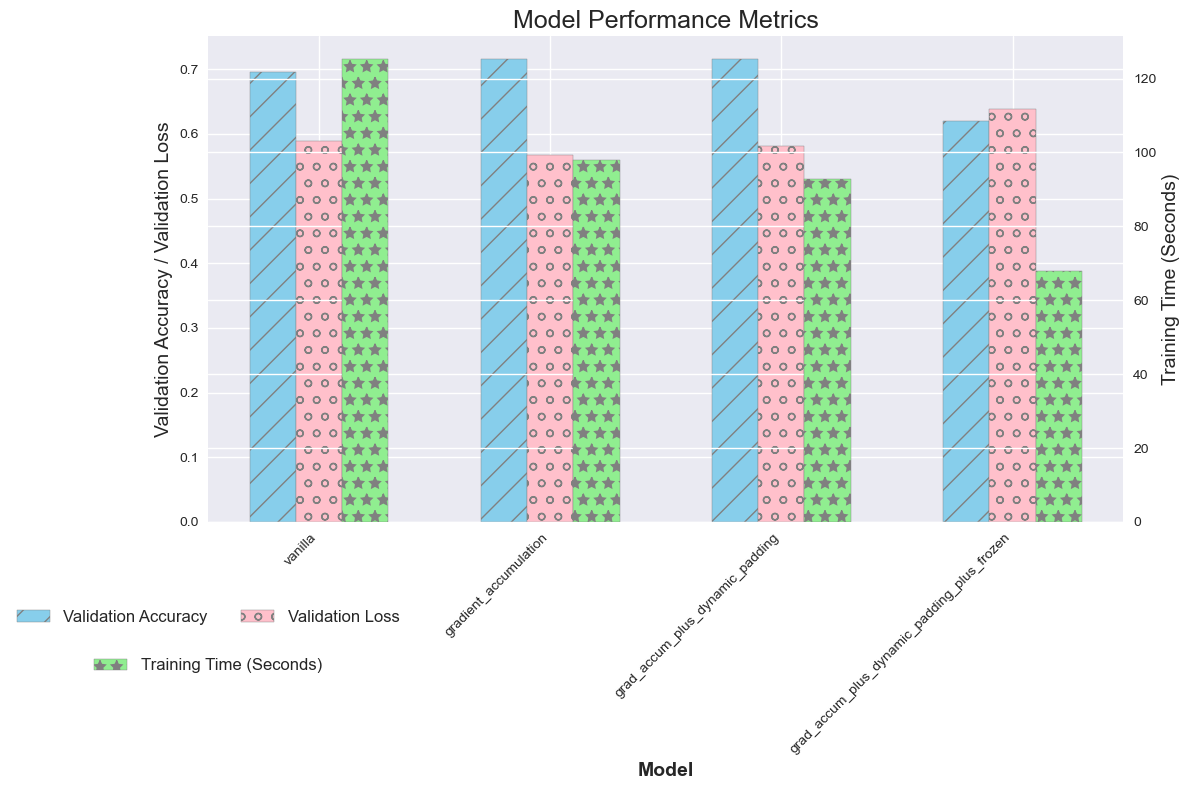

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the style
plt.style.use('seaborn')

# Extract keys (model types) and values (metrics) from the dictionary
models = list(final_model_metrics.keys())
train_time_seconds = [metrics['train_time_seconds'] for metrics in final_model_metrics.values()]
val_accuracy = [metrics['val_accuracy'] for metrics in final_model_metrics.values()]
val_loss = [metrics['val_loss'] for metrics in final_model_metrics.values()]

# Define bar width
bar_width = 0.2

# Define the position of the bars
r1 = np.arange(len(train_time_seconds))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bar plot
fig, ax1 = plt.subplots(figsize=(12, 8))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Colors and patterns
colors = ['skyblue', 'pink', 'lightgreen']
patterns = ['/', 'o', '*']

ax1.bar(r1, val_accuracy, color=colors[0], width=bar_width, edgecolor='grey', hatch=patterns[0], label='Validation Accuracy')
ax1.bar(r2, val_loss, color=colors[1], width=bar_width, edgecolor='grey', hatch=patterns[1], label='Validation Loss')
ax2.bar(r3, train_time_seconds, color=colors[2], width=bar_width, edgecolor='grey', hatch=patterns[2], label='Training Time (Seconds)')

# Adding xticks
ax1.set_xlabel('Model', fontweight='bold', fontsize=14)
ax1.set_xticks([r + bar_width for r in range(len(train_time_seconds))])
ax1.set_xticklabels(models, rotation=45, ha="right")  # Rotate labels

# Setting y-axis labels
ax1.set_ylabel('Validation Accuracy / Validation Loss', fontsize=14)
ax2.set_ylabel('Training Time (Seconds)', fontsize=14)

# Adding legend with increased size
ax1.legend(loc='upper center', bbox_to_anchor=(0, -0.15), shadow=True, ncol=2, prop={'size': 12})
ax2.legend(loc='upper center', bbox_to_anchor=(0, -0.25), shadow=True, ncol=2, prop={'size': 12})

# Set title
plt.title('Model Performance Metrics', fontsize=18)

# Prevent label overlap
plt.tight_layout()
plt.show()


In [47]:
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained('ai_user_grp_tmp')

In [57]:
from transformers import pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)


pipe([
    {
        "text": 'How many people live in Berlin?', 
        "text_pair": 'Berlin has a population of 3,520,031 in an area of 891.82 square kilometers.'
    },
    {
        "text": 'How many people live in Berlin?', 
        "text_pair": 'New York City is famous for the Metropolitan Museum of Art.'
    },
    {
        "text": 'How many people live in Berlin?', 
        "text_pair": 'Berlin is a wonderful city and has an area of 891.82 square kilometers.'
    }
])

[{'label': 'entailment', 'score': 0.5364819765090942},
 {'label': 'not_entailment', 'score': 0.8206643462181091},
 {'label': 'not_entailment', 'score': 0.5107059478759766}]